In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
from binance.client import Client
from binance.exceptions import BinanceAPIException
from secrets import secrets

In [2]:
BINANCE_API_KEY = secrets['BINANCE_API_KEY']
BINANCE_SECRET_KEY = secrets['BINANCE_SECRET_KEY']
BRIDGE = 'USDT'

client = Client(BINANCE_API_KEY, BINANCE_SECRET_KEY)
symbol = 'BAT' + BRIDGE
kline = client.get_klines(symbol=symbol, interval=Client.KLINE_INTERVAL_1HOUR)

In [3]:
kline[:5]

[[1612980000000,
  '0.42000000',
  '0.42140000',
  '0.41280000',
  '0.42140000',
  '1015398.07000000',
  1612983599999,
  '423713.81038700',
  1782,
  '470404.03000000',
  '196559.88430400',
  '0'],
 [1612983600000,
  '0.42140000',
  '0.42330000',
  '0.41100000',
  '0.42110000',
  '1227489.55000000',
  1612987199999,
  '511763.33189100',
  2268,
  '557766.55000000',
  '232483.39826900',
  '0'],
 [1612987200000,
  '0.42100000',
  '0.42170000',
  '0.40910000',
  '0.41020000',
  '1414811.53000000',
  1612990799999,
  '585904.94403300',
  2066,
  '510224.26000000',
  '211399.18464400',
  '0'],
 [1612990800000,
  '0.41020000',
  '0.42890000',
  '0.40860000',
  '0.42860000',
  '1640526.34000000',
  1612994399999,
  '688991.63313100',
  3177,
  '914897.32000000',
  '384408.00905700',
  '0'],
 [1612994400000,
  '0.42860000',
  '0.44140000',
  '0.42630000',
  '0.44010000',
  '1684748.46000000',
  1612997999999,
  '732913.32680300',
  3437,
  '915370.88000000',
  '398242.83659400',
  '0']]

In [4]:
cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseTime', 'QuoteVolume', 'NumberTrades',
        'TakerBuyBaseVolume', 'TakerBuyQuoteVolume', 'Ignore']
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'QuoteVolume', 'TakerBuyBaseVolume', 'TakerBuyQuoteVolume']
df = pd.DataFrame(kline, columns=cols)
df = df.drop(columns=['CloseTime', 'Ignore'])
df['Date'] = pd.to_datetime(df['Date'], unit='ms')
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
df['NumberTrades'] = df['NumberTrades'].astype('int')
df.tail()

,Date,Open,High,Low,Close,Volume,QuoteVolume,NumberTrades,TakerBuyBaseVolume,TakerBuyQuoteVolume
495,2021-03-03 10:00:00,0.6628,0.6906,0.6627,0.6760,3607921.47,2.448381e+06,6788,2006376.83,1.361624e+06
496,2021-03-03 11:00:00,0.6760,0.6850,0.6601,0.6720,2744326.68,1.846820e+06,4518,1401889.98,9.436607e+05
497,2021-03-03 12:00:00,0.6713,0.6986,0.6634,0.6909,3877559.61,2.665329e+06,7796,1789136.78,1.229942e+06
498,2021-03-03 13:00:00,0.6913,0.6942,0.6638,0.6699,3903485.65,2.638685e+06,6700,1720315.52,1.162846e+06
499,2021-03-03 14:00:00,0.6701,0.6701,0.6608,0.6667,762415.74,5.068397e+05,1146,429344.48,2.854803e+05


In [5]:
array_date = np.array(df['Date'])
array_open = np.array(df['Open'])
array_high = np.array(df['High'])
array_low = np.array(df['Low'])
array_close = np.array(df['Close'])
array_volume = np.array(df['Volume'])

array_open.size, array_high.size, array_low.size, array_close.size,

(500, 500, 500, 500)

### Finding Highest Values within k Periods

In [6]:
# kperiods are 14 array start from 0 index
kperiods = 8

y = 0
z = 0
array_highest = []

for x in range(0, array_high.size - kperiods):
    z = array_high[y]
    for j in range(0, kperiods):
        if z < array_high[y+1]:
            z = array_high[y+1]
        y += 1
    # creating list highest of k periods
    array_highest.append(z)
    y -= (kperiods - 1)

array_highest[:5]

[0.4561, 0.4561, 0.4561, 0.4561, 0.4768]

### Finding Lowest Values within k Periods

In [7]:
y = 0
z = 0
array_lowest = []

for x in range(0, array_low.size - kperiods):
    z = array_low[y]
    for j in range(0, kperiods):
        if z > array_low[y+1]:
            z = array_low[y+1]
        y += 1
    # creating list highest of k periods
    array_lowest.append(z)
    y -= (kperiods - 1)
    
array_lowest[:5]

[0.4086, 0.4086, 0.4086, 0.4086, 0.4263]

### Finding %K Line Values

In [8]:
K_value = []
for x in range(kperiods, array_close.size):
    k = ((array_close[x] - array_lowest[x - kperiods]) * 100 /
         (array_highest[x - kperiods] - array_lowest[x - kperiods]))
    K_value.append(k)

len(K_value)

492

### Finding %D Line Values

In [9]:
y = 0
dperiods = 3
D_value = [None, None]
mean = 0

for x in range(0, len(K_value) - dperiods + 1):
    this_sum = 0
    for j in range(0, dperiods):
        this_sum += K_value[y]
        y += 1
    mean = this_sum / dperiods
    D_value.append(mean)
    y -= (dperiods - 1)

len(D_value)

492

### Finding %J Line Values

In [10]:
J_value = [None, None]
for x in range(0, len(D_value) - dperiods + 1):
    j = (D_value[x+2] * 3) - (K_value[x+2] * 2)
    J_value.append(j)

len(J_value)

492

### Output

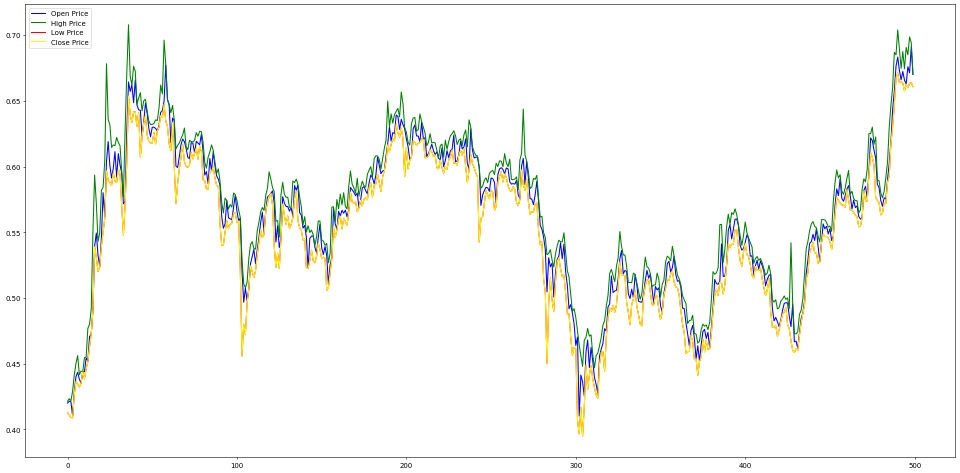

In [11]:
plt.figure(figsize=(24, 12), dpi=50, facecolor='w', edgecolor='k')
plt.plot(array_open, color='blue', label='Open Price')
plt.plot(array_high, color='green', label='High Price')
plt.plot(array_low, color='red', label='Low Price')
plt.plot(array_low, color='yellow', label='Close Price')
plt.legend()
plt.show();

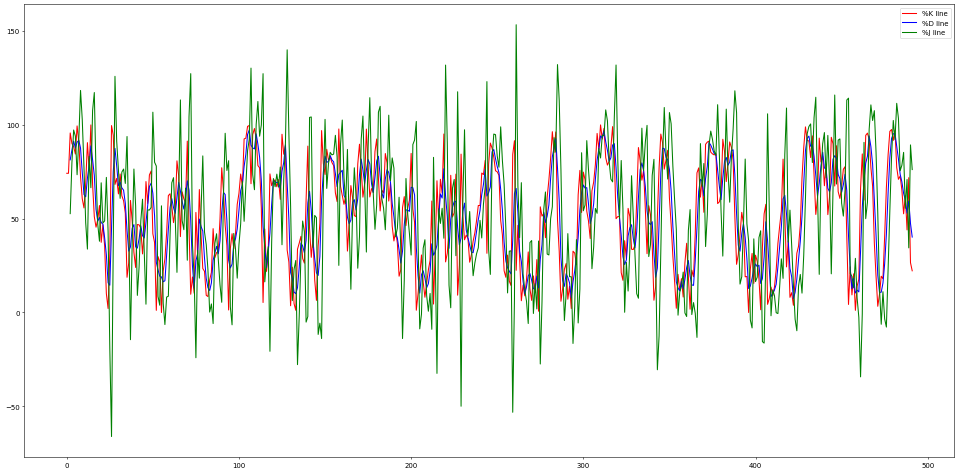

In [12]:
plt.figure(figsize=(24, 12), dpi=50, facecolor='w', edgecolor='k')
ax = plt.gca() 
plt.plot(K_value, color='red', label = '%K line')
plt.plot(D_value, color='blue', label = '%D line')
plt.plot(J_value, color='green', label = '%J line')
plt.legend()
plt.show();

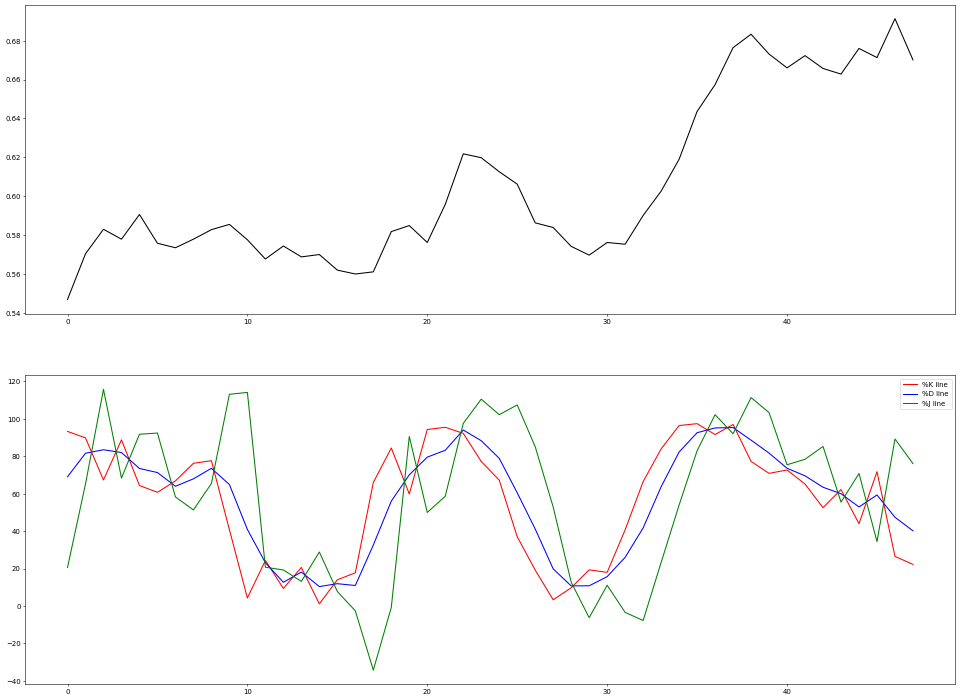

In [13]:
limit = 48

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(24, 18), dpi=50, facecolor='w', edgecolor='k')
ax[0].plot(array_open[-limit:], color='black', label='Open Price')
# ax[0].plot(array_close[-limit:], color='red', label='Close Price')
ax[1] = plt.gca() 
ax[1].plot(K_value[-limit:], color='red', label='%K line')
ax[1].plot(D_value[-limit:], color='blue', label='%D line')
ax[1].plot(J_value[-limit:], color='green', label='%J line')
plt.legend();
plt.show();